# Reading the simulation data

The simulation is described in [Banerjee et. al. (2020)](https://arxiv.org/pdf/1906.12026.pdf). Both simulation box and cosmology parameters can be found in [`cosmolgy.py`](../src/cosmology.py).

---
## 1. Halo Catalogue
The catalogue contains `ROCKSTAR` haloes with masses $\log_{10} M_{\rm 200m}\in\left[ 13.0 , 15.4\right]$.

Lets open the HDF and print the names of the datasets in it.

In [1]:
import sys
from os.path import join

sys.path.append("/home/edgarmsc/Projects/HaloModelCF/")

import h5py as h5
import numpy as np
import matplotlib.pyplot as plt

from src.config import SRC_PATH, MBINEDGES, MEMBSIZE, MBINSTRS

In [2]:
with h5.File(join(SRC_PATH, 'halo_catalogue.h5'), 'r') as hdf:
    print(hdf.keys())

<KeysViewHDF5 ['ID', 'M200m', 'Morb', 'Mt', 'OHID', 'PID', 'R200m', 'Rt', 'STATUS', 'Vmax', 'vx', 'vy', 'vz', 'x', 'y', 'z']>


The relevant keys are:

| Key | Description | Units |
| --- | --- | --- |
| `OHID` | Halo ID |
| `M200m`, `Mt`, `Morb` | Mass definitions | $10^{10}{\rm M}_{\odot}$ |
| `R200m`, `Rt` | Halo radius definitions | $h^{-1}$ Mpc |
| `x`, `y`, `z` | Halo coordinates in the box | $h^{-1}$ Mpc |
| `vx`, `vy`, `vz` | Halo velocities | km s $^{-1}$ |
| `vmax` | Maximum circular velocity | km s $^{-1}$ |

> Not all haloes have $M_{\rm orb}$. To compute the orbiting mass we need (so far) the full orbits of the particles that belong to each halo. This translates into only having the orbiting mass for 46% of the haloes in the catalogue. In other words, *all particles in the orbits catalogue match to a halo, but no all haloes have particle orbits.*

We select haloes by mass in logarithmic bins. Notice they are not uniformly separated.

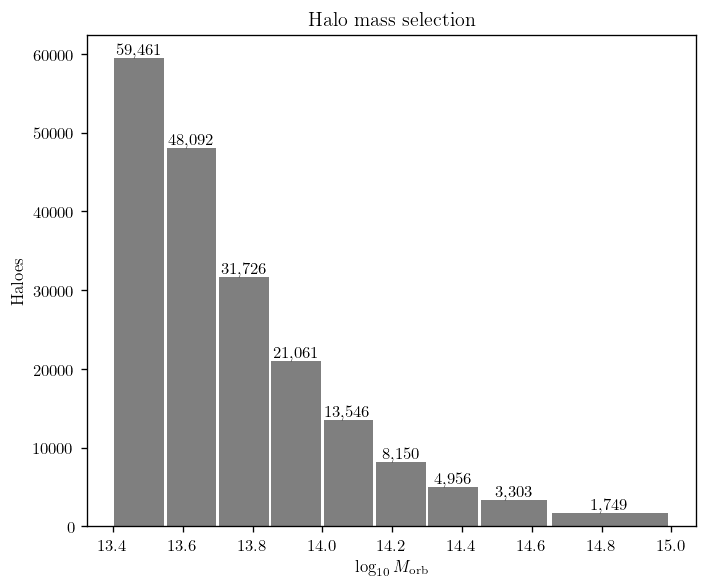

In [3]:
with h5.File(join(SRC_PATH, 'halo_catalogue.h5'), 'r') as hdf:
    morb = hdf['Morb'][()]

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "figure.dpi": 120})
plt.figure(figsize=(6, 5))
plt.title('Halo mass selection')
counts, _, bars = plt.hist(np.log10(morb[morb>0]), bins=MBINEDGES, rwidth=0.95,
                           color='k', alpha=0.5)
plt.bar_label(bars, fmt='{:,.0f}', color='k')
plt.xlabel(r'$\log_{10} M_{\rm orb}$')
plt.ylabel(r'Haloes')
plt.tight_layout();

> I recommend you use the largest mass bin for code development as it has less haloes (runs faster), and since they are more massive, they contain a lot of particles (less noisy statistics).

---

## 2. Particle Catalogue

We have the particles at $z=0$, which corresponds to snapshot 99 in the simulation. These are 1% particles, which means only 1 every 100 particles was stored when they ran the simulation and all others were thrown away. This is standard practice to save memory space.

Even 1% of the particles can be a lot and slow things down. For this reason we randomly sampled the catalogue and produced downsampled versions of the same snapshot (1%) for 1 in every 1, 5, 10, 50, 100, 500, 1000, 10000. So far, working with a sample factor of 100 seems good enough.

Here is an example on how to access the particles for a downsample factor `ds`.

In [4]:
ds = 100
with h5.File(join(SRC_PATH, 'particle_catalogue.h5'), 'r') as hdf:
    print(hdf[f'snap99/{ds}'].keys())

<KeysViewHDF5 ['PID', 'vx', 'vy', 'vz', 'x', 'y', 'z']>


---

## 3. Particle Orbit Catalogue

We drew a 5 $h^{-1}$ Mpc box around each halo, selected all the particles inside that box, then stored their positions and velocities relative to the halo, their ids and the halo id. Naturally, some particles fall inside the box for different haloes. So it is possible to find a repeated `PID` with all different positions and velocities. 
> A particle can only be orbiting a single halo. More on this at [Garcia et al. (2022)](https://arxiv.org/abs/2207.11827)


This is where things become interesting. How do we know the particles' distance to the centre of a halo as a function of time? The core idea is that by looking at the particles that make up a halo at $z=0$, we can traceback its relative position and velocity to that halo for every timestep (snapshot). This is fairly complicated and computationally demanding. However this was done already done for us so you needn't worry about that.

We have the orbits of particles belonging to haloes in the mass range $\log_{10} M_{\rm 200m}\in\left[ 13.0 , 15.4\right]$ with 100 timesteps. The zeroth element of the orbit array corresponds to $a=1$ and the last to $a=0.2$, where $a=(1+z)^{-1}$ is the scale factor.

The orbits are stored in a 0.84 TB HDF split into 10 GB parts. To read it you need to specify the *exact* size (`MEMBSIZE`) of each part. 
> If you change the `MEMBSIZE` value you will not be able to access the files.

Each file has name `orbit_catalogue_#.h5`, where `#` is the part number. You need to tell `h5py` that the file you are reading is split into multiple. This is done by passing the file name with formatting enabled as `orbit_catalogue_%d.h5`, and with the keyword argument `driver='family'`. Always open in **read mode only** and within a **context manager**. The latter is not critical but the files can be corrupted if the program does not exit properly.

Lets open the HDF and print the names of the datasets in it.

In [5]:
with h5.File(join(SRC_PATH, 'orbits/orbit_catalogue_%d.h5'), 'r', driver='family', memb_size=MEMBSIZE) as hdf:
    print(hdf.keys())

<KeysViewHDF5 ['HID', 'PID', 'Rp', 'Vrp', 'Vtp']>


Here `HID` corresponds to `OHID` in the halo catalogue, and `PID` to the particle ID in the [particles catalgue](#2.-Particle-Catalogue).

As you can see, we already have the radial distance to the halo centre `Rp`, and the relative radial and tangential velocities, `Vrp` and `Vtp` respectively. These three are arrays with N rows (one per particle) and 100 columns (one per time step).

> Mostly, we **ONLY** need to work with the zeroth element of the radius and velocities arrays.


> The tangential velocity is always positive in this catalogue.

Running the cell above takes less than a second. This is because you are only accessing *metadata* of the HDF. However it will take a while to load any array, so be patient. Also, be mindful of the size of the arrays before loading into memory. Fully loading `Rp` (N by 100) will need ~200 GB of RAM!
> When loading an array from the orbit catalogue, please use something like `hdf['Rp'][:, 0]` to load the last timestep (at $z=0$) and avoid loading the full array like `hdf['Rp'][()]` unless you know what you are doing.

---

## 4. Orbiting Particle Classification

The tags for the particles are booleans and the convention we are using is the following:
- `0` or `False` for infalling particles,
- `1` or `True` for orbiting particles.

The classification file contains a single array, and each row has a 1-1 correspondence to the rows in the [orbit catalgue](#3.-Particle-Orbit-Catalogue).

In [6]:
with h5.File(join(SRC_PATH, 'particle_classification.h5'), 'r') as hdf:
    print(hdf.keys())
    print(f"There are {len(hdf['CLASS']):,} orbits stored!")

<KeysViewHDF5 ['CLASS']>
There are 707,607,733 orbits stored!


---

## 5. Additional

At some point you might need to use the orbits of particles that belong to a single halo (this takes a long time to do for all haloes). Or maybe just speed up loading all haloes or particles of a given mass bin. Luckily fo you, I already did all this so you can simply use my dictionaries and masks, but feel free to code your own.

### 5.1 Halo catalogue mass bin masks.
Halo mass bins masks are located at `data/mass_bin_haloes.h5`. And the keys for each dataset are the elements of `MBINSTRS` defined in the [`config.py`](../src/config.py) file. The size of the mask and ordering match the [halo catalogue](#1-halo-catalogue).

In [7]:
with h5.File(join(SRC_PATH, 'data/mass_bin_haloes.h5'), 'r') as hdf:
    # Print the number of haloes in each mass bin. This should match the counts
    # in the histogram above (with pretty f-string formatting).
    for mbin in MBINSTRS:
        print(f'{(hdf[mbin][()]>0).sum():>8,}')

  59,461
  48,092
  31,726
  21,061
  13,546
   8,150
   4,956
   3,303
   1,749


### 5.2 Particle orbit catalogue mass bin masks.
Particle orbit masks for mass bin selection are located at `data/mass_bin_particles.h5`.

In [8]:
with h5.File(join(SRC_PATH, 'data/mass_bin_particles.h5'), 'r') as hdf:
    # Print the number of particles with orbits in each mass bin.
    for mbin in MBINSTRS:
        print(f'{(hdf[mbin][()]>0).sum():>12,}')

 138,483,916
 124,980,088
  97,497,449
  76,182,601
  58,098,979
  43,259,623
  33,362,432
  38,224,268
  32,848,989


### 5.3 Partcle Orbit to Halo ID Match.

What if you only need to select the particles' orbits for a single halo. Then, you'd select all the rows in the orbit catalogue that match the `OHID` you are interested in. Quite simple but very slow when you are looking through almost a billion of rows. 

For this reason I also provide a lookup/hash table for this matching located at `halo_particle_dict.h5`. This is basically a dictionary where each key in the file is the `OHID` of the halo. The dataset under each key contains the indices of the particles in the orbit catalogue that belong to said halo. Some keys contain empty arrays (i.e. no particles for that halo). You need to pass the halo ID as a string to load the HDF dataset. I include a snippet below on how I read the dictionary.

In [9]:
with h5.File(join(SRC_PATH, 'halo_particle_dict.h5'), 'r') as hdf_dict,\
    h5.File(join(SRC_PATH, 'halo_catalogue.h5'), 'r') as hdf_cat:
    # Load all halo ids with an Morb
    morb_mask = (hdf_cat['Morb'][()] > 0)
    hid = hdf_cat['OHID'][()]
    good_hid = hid[(hdf_cat['Morb'][()] > 0)]  # with particles
    
    # Then you can iterate over haloes with particles. Since OHID is the name of
    # the dataset (key) in the dictionary, we just pass it as a string.
    # NOTE: for demonstration purposes, just print the indices and the number of 
    # particles for the first five haloes.
    for key in good_hid[:5]:
        p_idx = hdf_dict[str(key)][()]
        print(f'{len(p_idx):>8,} particles for OHID {key} Indices: ', p_idx)

  55,342 particles for OHID 24 Indices:  [697611523 697611524 697611525 ... 697666862 697666863 697666864]
  55,627 particles for OHID 66 Indices:  [697712641 697712642 697712643 ... 697768265 697768266 697768267]
  16,409 particles for OHID 81 Indices:  [125369473 125369474 125369475 ... 125385879 125385880 125385881]
   6,352 particles for OHID 87 Indices:  [75121056 75121057 75121058 ... 75127405 75127406 75127407]
  11,523 particles for OHID 93 Indices:  [625049322 625049323 625049324 ... 625060842 625060843 625060844]
